In [1]:
import QDNS
import logging
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

In [2]:
class Alice(QDNS.Node):
    def __init__(self):
        super().__init__("Alice")
        self.create_new_application(self.alice_default_app)

    @staticmethod
    def alice_default_app(app: QDNS.Application):
        my_pairs = app.send_entangle_pairs(512, "Bob")
        
        if my_pairs is None:
            print("Sending pairs is failed.")
            return
        
        results = app.measure_qubits(my_pairs)
        app.put_simulation_result(results)

In [3]:
class Bob(QDNS.Node):
    def __init__(self):
        super().__init__("Bob")
        self.create_new_application(self.bob_default_app)

    @staticmethod
    def bob_default_app(app: QDNS.Application):
        op = app.wait_next_qubits(512)
        my_pairs, pair_length = op
        
        results = app.measure_qubits(my_pairs)
        app.put_simulation_result(results)

In [4]:
def main(backend, length: float, channel):
    logging.basicConfig(level=logging.ERROR)
    
    # Build network
    alice, bob = Alice(), Bob()
    net = QDNS.Network(alice, bob)
    net.add_channels(alice, bob, length=length) #km
    
    # Set needed quantum resources.
    if backend == QDNS.STIM_BACKEND:
        frames = {2: 10000}
        core_count = 1
    else:
        core_count = int(QDNS.core_count / 2)
        frames = {
            2: {
                1: 64,
                2: 512
            }
        }
    
    # Create backend confuguration.
    backend_conf = QDNS.BackendConfiguration(backend, core_count, frames)
    
    # Create new noise with custom scramble channel.
    noise = QDNS.NoisePattern(
        0.02, 0.01, 0.005,
        scramble_channel=channel
    )
    
    # Simulate network.
    sim = QDNS.Simulator()
    results = sim.simulate(net, backend_conf, noise)
    
    # Get the user values.
    alice_results = results.user_dumpings(alice.label, QDNS.DEFAULT_APPLICATION_NAME)
    bob_results = results.user_dumpings(bob.label, QDNS.DEFAULT_APPLICATION_NAME)
    
    # Return error rate.
    count = 0
    for i in range(alice_results.__len__()):
        if alice_results[i] == bob_results[i]:
            count += 1
    return count / alice_results.__len__()

In [5]:
def stub(length: float, channel):
    errors = list()
    rate = main(QDNS.QISKIT_BACKEND, length, channel)
    errors.append(rate)
    rate = main(QDNS.CIRQ_BACKEND, length, channel)
    errors.append(rate)
    rate = main(QDNS.STIM_BACKEND, length, channel)
    errors.append(rate)
    return errors

In [6]:
# Runs for 5 legth * 3 backend = 15 run
def test(channel):
    error_rates = list()
    for i in range(1, 102, 20):
        error_rates.append([i, stub(i, channel)])
    return error_rates

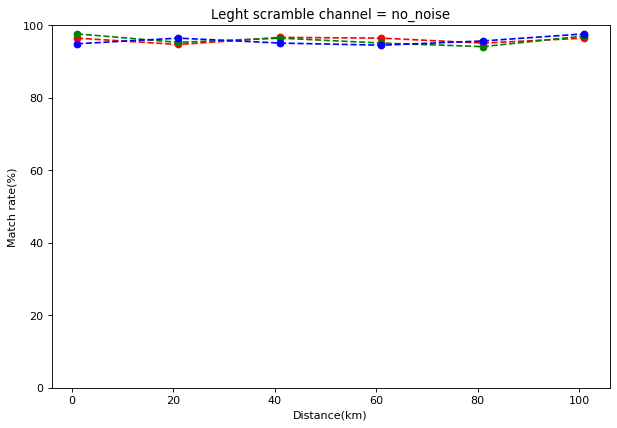

In [9]:
# Simulate with no noise between Alice and Bob fibre cable.
lengths = list()
plot_cirq = list()
plot_qiskit = list()
plot_stim = list()

for errors in test(QDNS.no_noise_channel):
    length, rates = errors
    qiskit, cirq, stim = rates
    lengths.append(length)
    plot_cirq.append(cirq * 100)
    plot_qiskit.append(qiskit * 100)
    plot_stim.append(stim * 100)
    
figure(figsize=(9, 6), dpi=80)
plt.title("Leght scramble channel = no_noise")
plt.plot(lengths, plot_cirq, 'ro--')
plt.plot(lengths, plot_qiskit, 'go--')
plt.plot(lengths, plot_stim, 'bo--')
plt.ylim(0, 100)
plt.xlabel("Distance(km)")
plt.ylabel("Match rate(%)")
plt.show()

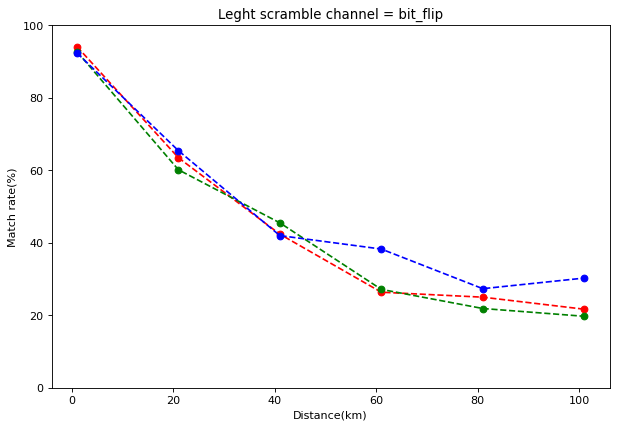

In [10]:
# Simulate with bit flip between Alice and Bob fibre cable.
lengths = list()
plot_cirq = list()
plot_qiskit = list()
plot_stim = list()

for errors in test(QDNS.bit_flip_channel):
    length, rates = errors
    qiskit, cirq, stim = rates
    lengths.append(length)
    plot_cirq.append(cirq * 100)
    plot_qiskit.append(qiskit * 100)
    plot_stim.append(stim * 100)
    
figure(figsize=(9, 6), dpi=80)
plt.title("Leght scramble channel = bit_flip")
plt.plot(lengths, plot_cirq, 'ro--')
plt.plot(lengths, plot_qiskit, 'go--')
plt.plot(lengths, plot_stim, 'bo--')
plt.ylim(0, 100)
plt.xlabel("Distance(km)")
plt.ylabel("Match rate(%)")
plt.show()

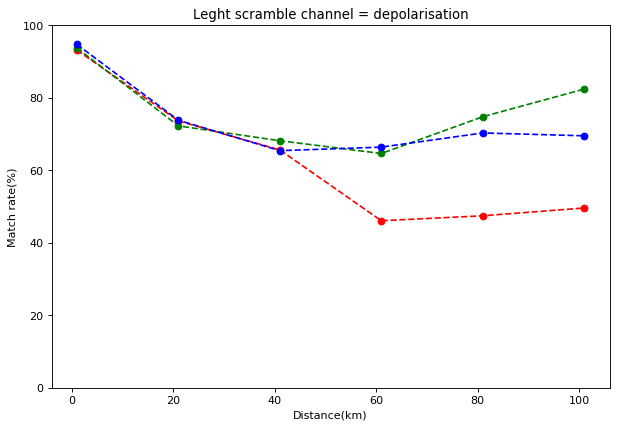

In [11]:
# Simulate with depolarisation between Alice and Bob fibre cable.
lengths = list()
plot_cirq = list()
plot_qiskit = list()
plot_stim = list()

for errors in test(QDNS.depolarisation_channel):
    length, rates = errors
    qiskit, cirq, stim = rates
    lengths.append(length)
    plot_cirq.append(cirq * 100)
    plot_qiskit.append(qiskit * 100)
    plot_stim.append(stim * 100)
    
figure(figsize=(9, 6), dpi=80)
plt.title("Leght scramble channel = depolarisation")
plt.plot(lengths, plot_cirq, 'ro--')
plt.plot(lengths, plot_qiskit, 'go--')
plt.plot(lengths, plot_stim, 'bo--')
plt.ylim(0, 100)
plt.xlabel("Distance(km)")
plt.ylabel("Match rate(%)")
plt.show()